In [162]:
import pickle
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
from pandas.core.frame import DataFrame

## example

```bash
nohup parallel 'python3 experiment_dbpedia_14.py --group_id dbpedia_14_20240109 --n_sample_from 5 --n_sample_to 25 --n_trials 10 --verification {1} --strategy {2}' ::: themselves dataset ::: normal super > results/ex_20240109.log &

In [163]:
group_id = "dbpedia_14_20240110"

# load result
result_files = glob.glob(f"./results/{group_id}/*.pickle")
results = []
for file in result_files:
    with open(file, "rb") as f:
        tmp = pickle.load(f)
        # print("verification: ", tmp["args"].verification)
        # print("strategy: ", tmp["args"].strategy)
        if tmp["args"].verification == "themselves" and tmp["args"].strategy == "normal":
            results.append(tmp)

# create plots folder
os.makedirs(f"./plots/{group_id}/", exist_ok=True)

print(results[0]["result"])

[[{'class label': 'Company', 'TP': 5, 'TN': 0, 'FP': 0, 'FN': 5, 'precision': 1.0, 'negative examples': ['apple', 'banana', 'orange', 'grape', 'pineapple'], 'positive examples': ['Apple', 'Google', 'Amazon', 'Microsoft', 'Facebook'], 'accuracy': 0.5, 'n_samples': 5}, {'class label': 'EducationalInstitution', 'TP': 5, 'TN': 0, 'FP': 0, 'FN': 5, 'precision': 1.0, 'negative examples': ['apple', 'banana', 'cherry', 'durian', 'elderberry'], 'positive examples': ['University of California, Berkeley', 'Harvard University', 'Massachusetts Institute of Technology', 'Stanford University', 'University of Oxford'], 'accuracy': 0.5, 'n_samples': 5}, {'class label': 'Artist', 'TP': 2, 'TN': 0, 'FP': 3, 'FN': 5, 'precision': 0.4, 'negative examples': ['apple', 'banana', 'carrot', 'dragonfruit', 'eggplant'], 'positive examples': ['Pablo Picasso', 'Beyoncé', 'Leonardo da Vinci', 'Taylor Swift', 'Vincent van Gogh'], 'accuracy': 0.2, 'n_samples': 5}, {'class label': 'Athlete', 'TP': 5, 'TN': 0, 'FP': 0, 

In [164]:
# make results into dataframe
df_columns = ["model", "label", "accuracy", "precision", "TP", "TN", "FP", "FN", "n_samples", "n_trials", "strategy"]
df_data = []
time_elapsed = 0
ex_id = ""
args = {}
for r in results:
    # when different args, display it
    if args != r["args"]:
        print("#data: ", len(df_data))
        print("experiment settings: ", r["args"])
    args = r["args"]
    n_trials = args.n_trials
    max_retry = args.max_retry
    model = args.model
    strategy = args.strategy
    # if args.verification == "themselves" or strategy == "normal":
    #     continue
    for trial in r["result"]:
        for sample in trial:
            df_data.append([
                model,
                sample["class label"],
                sample["accuracy"],
                sample["precision"],
                sample["TP"],
                sample["TN"],
                sample["FP"],
                sample["FN"],
                sample["n_samples"],
                n_trials,
                strategy,
            ])
    time_elapsed = int(r["finish_time"]) - int(r["start_time"])
    ex_id = r["experiment_id"]
df_results = pd.DataFrame(df_data, columns=df_columns)
print("---")
print("time elapsed: ", time_elapsed)
print("experiment id: ", ex_id)
print("#data: ", len(df_data))
# print("total #data should be:", 14*n_trials*5)
print(df_results.loc[0:14].to_latex(escape=True))

#data:  0
experiment settings:  Namespace(group_id='dbpedia_14_20240110', n_trials=10, n_sample_from=5, n_sample_to=25, n_sample_step=5, model='gpt-3.5-turbo-instruct', logging=True, max_retry=3, test=False, strategy='normal', verification='themselves')
---
time elapsed:  11414
experiment id:  f45d86b98012ecdb668a02dda9c2204e
#data:  677
\begin{tabular}{lllrrrrrrrrl}
\toprule
 & model & label & accuracy & precision & TP & TN & FP & FN & n\_samples & n\_trials & strategy \\
\midrule
0 & gpt-3.5-turbo-instruct & Company & 0.500000 & 1.000000 & 5 & 0 & 0 & 5 & 5 & 10 & normal \\
1 & gpt-3.5-turbo-instruct & EducationalInstitution & 0.500000 & 1.000000 & 5 & 0 & 0 & 5 & 5 & 10 & normal \\
2 & gpt-3.5-turbo-instruct & Artist & 0.200000 & 0.400000 & 2 & 0 & 3 & 5 & 5 & 10 & normal \\
3 & gpt-3.5-turbo-instruct & Athlete & 0.500000 & 1.000000 & 5 & 0 & 0 & 5 & 5 & 10 & normal \\
4 & gpt-3.5-turbo-instruct & OfficeHolder & 0.500000 & 1.000000 & 5 & 0 & 0 & 5 & 5 & 10 & normal \\
5 & gpt-3.5-tu

In [165]:
# group by n_sample
res_g_sample = df_results.groupby(by=["n_samples"], as_index=False).mean(["accuracy", "precision"])
print(res_g_sample.to_latex(escape=True,index=False))

cor = res_g_sample[['n_samples', 'accuracy', 'precision']].corr()

print(cor.to_latex(escape=True))

\begin{tabular}{rrrrrrrr}
\toprule
n\_samples & accuracy & precision & TP & TN & FP & FN & n\_trials \\
\midrule
5 & 0.423188 & 0.828986 & 4.144928 & 0.086957 & 0.855072 & 4.913043 & 10.000000 \\
10 & 0.363359 & 0.703053 & 7.030534 & 0.236641 & 2.969466 & 9.763359 & 10.000000 \\
15 & 0.339706 & 0.652451 & 9.786765 & 0.404412 & 5.213235 & 14.595588 & 10.000000 \\
20 & 0.313869 & 0.597810 & 11.956204 & 0.598540 & 8.043796 & 19.401460 & 10.000000 \\
25 & 0.326667 & 0.612444 & 15.311111 & 1.022222 & 9.688889 & 23.977778 & 10.000000 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
 & n\_samples & accuracy & precision \\
\midrule
n\_samples & 1.000000 & -0.889499 & -0.912541 \\
accuracy & -0.889499 & 1.000000 & 0.998397 \\
precision & -0.912541 & 0.998397 & 1.000000 \\
\bottomrule
\end{tabular}


In [166]:
# plot accuracy and precision with df_results
# x axis: label
# y axis: accuracy/precision (average of all trials)
# group by n_sample

def plot_acc_prec_by_verification(df: DataFrame, verification="dataset", fontsize=12):
    # df_target = df.groupby(by=["strategy", "n_samples", "label"], as_index=False)
    df_target = df
    # plot
    plt.figure(figsize=(16, 8))
    plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.1)
    # plt.title(f"{model} - dbpedia_14 dataset - {group_id}")
    # plt.xlabel("n_samples")
    # plt.ylim(0, 1)

    sub_acc = plt.subplot(1, 2, 1)
    # sub_acc.set_title("accuracy", fontsize=fontsize)
    sub_acc.set_xlabel("n_samples", fontsize=fontsize)
    sub_acc.set_ylabel("accuracy", fontsize=fontsize)
    sub_acc.set_ylim(0, 1.05)
    
    sub_prec = plt.subplot(1, 2, 2)
    # sub_prec.set_title("precision", fontsize=fontsize)
    sub_prec.set_xlabel("n_samples", fontsize=fontsize)
    sub_prec.set_ylabel("precision", fontsize=fontsize)
    sub_prec.set_ylim(0, 1.05)
    
    labels = []
    n_list = []
    # get average of accuracy and precision for each label group by n_sample
    for l, klass in df_target.groupby(by="label"):
        precs_by_n_sample = []
        accs_by_n_sample = []
        n_list = []
        for n_sample, data in klass.groupby(by="n_samples"):
            n_list.append(n_sample)
            precs_by_n_sample.append(data["precision"].mean())
            accs_by_n_sample.append(data["accuracy"].mean())
        sub_prec.plot(n_list, precs_by_n_sample, label=l)
        sub_acc.plot(n_list, accs_by_n_sample, label=l)
        labels.append(l)
    # plt.xticks(n_list)
    plt.legend(labels, loc="lower center", bbox_to_anchor=(0, 1), ncol=5, fontsize=fontsize)
    
    # save images
    plt.savefig(f"./plots/{group_id}/dbpedia14_{strategy}-{verification}-{ex_id}.pdf")


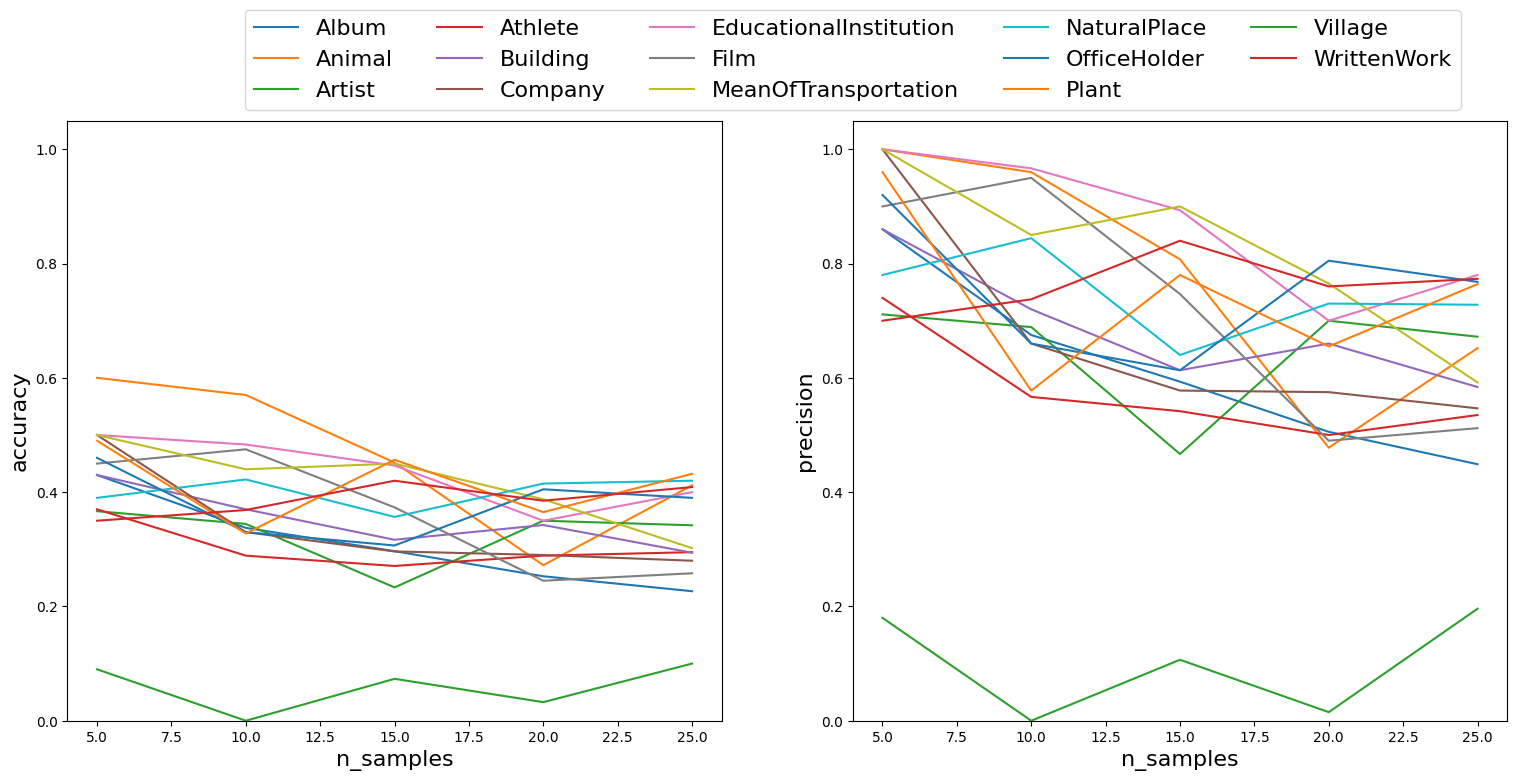

In [167]:
plot_acc_prec_by_verification(df_results, fontsize=16)